<a href="https://colab.research.google.com/github/yuzaffi/Predict-Student-Dropout-XGBoost-and-Neural-Networks/blob/main/Predict_Student_Dropout_XGBoost_and_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# General Utilities
from datetime import datetime
import numpy as np
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Neural Networks (TensorFlow / Keras)
from tensorflow import keras
from tensorflow.keras import layers, metrics

# Model Selection & Evaluation (scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score
)

# XGBoost
from xgboost import XGBClassifier

# Warnings Handling
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Stage 1

## PreProcess

In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=1pA8DDYmQuaLyxADCOZe1QaSQwF16q1J6"
df = pd.read_csv(file_url)

In [ ]:
# View df
print("Shape:", df.shape)
df.head()

Shape: (25059, 16)


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen


In [ ]:
# Drop 'LearnerCode'
df.drop(columns=['LearnerCode'], inplace=True)

In [ ]:
# Convert DOB to Age
df['DateofBirth'] = pd.to_datetime(df['DateofBirth'], dayfirst=True, errors='coerce')
df['Age'] = (pd.to_datetime("today") - df['DateofBirth']).dt.days // 365
df.drop(columns=['DateofBirth'], inplace=True)

In [ ]:
# Drop columns with more than 200 unique values
print("Unique counts per column:")
print(df.nunique())

high_card_cols = [col for col in df.columns if df[col].nunique() > 200]
df.drop(columns=high_card_cols, inplace=True)

print("Dropped columns:", high_card_cols)

Unique counts per column:
CentreName                 19
BookingType                 2
LeadSource                  7
DiscountType               11
Gender                      2
Nationality               151
HomeState                2448
HomeCity                 5881
CourseLevel                 4
CourseName                172
IsFirstIntake               2
CompletedCourse             2
ProgressionDegree        2616
ProgressionUniversity      40
Age                        38
dtype: int64
Dropped columns: ['HomeState', 'HomeCity', 'ProgressionDegree']


In [ ]:
# Drop columns with >50% missing
missing_percent = df.isnull().mean() * 100
print(missing_percent)

cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)

print("\nDropped columns with >50% missing:", cols_to_drop)

CentreName                0.000000
BookingType               0.000000
LeadSource                0.000000
DiscountType             69.691528
Gender                    0.000000
Nationality               0.000000
CourseLevel               0.000000
CourseName                0.000000
IsFirstIntake             0.000000
CompletedCourse           0.000000
ProgressionUniversity     0.000000
Age                       0.000000
dtype: float64

Dropped columns with >50% missing: ['DiscountType']


In [ ]:
# Binary encode target variable (dropout=1)
df['Dropout'] = df['CompletedCourse'].map({'Yes': 0, 'No': 1})
df.drop(columns=['CompletedCourse'], inplace=True)

In [ ]:
# Ordinal encode ordinal data
course_level_order = ['Foundation', 'International Year One', 'International Year Two', 'Pre-Masters']

df['CourseLevel'] = pd.Categorical(df['CourseLevel'], categories=course_level_order, ordered=True)
df['CourseLevel'] = df['CourseLevel'].cat.codes

In [ ]:
# One hot encode categorical data
categorical_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
# Convert all boolean columns to int (0/1)
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})

In [ ]:
df.head()

,CourseLevel,IsFirstIntake,Age,Dropout,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,CentreName_ISC_Huddersfield,CentreName_ISC_Kingston,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
0,3,1,27,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,27,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,0,25,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2,1,26,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,3,1,29,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


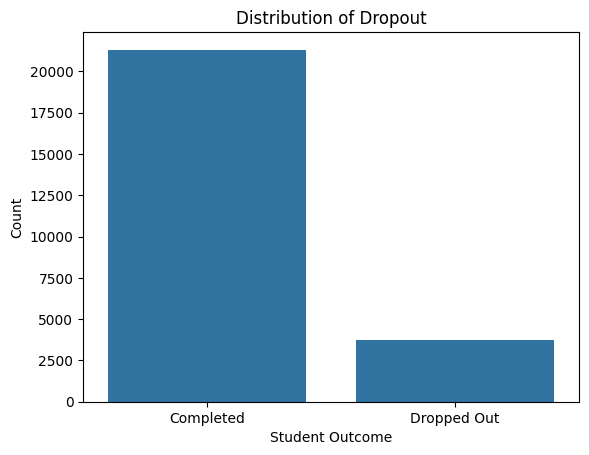

In [ ]:
# Visualies dropout count
sns.countplot(data=df, x='Dropout')
plt.title('Distribution of Dropout')
plt.xticks([0, 1], ['Completed', 'Dropped Out'])
plt.xlabel('Student Outcome')
plt.ylabel('Count')
plt.show()

In [ ]:
# Features and target
X1 = df.drop(columns=['Dropout'])
y1 = df['Dropout']

# Train/test split
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1,
    test_size=0.2,
    random_state=42,
    stratify=y1
)

## NN

In [ ]:
# --- COMMON FUNCTIONS (reused for all stages) ---

def build_and_train_nn_model(
    X_train,
    y_train,
    n_layers=2,
    n_neurons=64,
    activation='relu',
    output_activation='sigmoid',
    optimizer='adam',
    loss='binary_crossentropy',
    metric_list=None,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=0
):
    """
    Build, compile and fit a simple feed-forward neural network.
    Returns the trained model and the Keras History object.
    """
    # avoid mutable default argument
    if metric_list is None:
        metric_list = ['accuracy', metrics.AUC(name='auc')]

    # Build model
    model = keras.Sequential()
    model.add(keras.Input(shape=X_train.shape[1:]))  # Input layer
    for _ in range(n_layers):
        model.add(layers.Dense(n_neurons, activation=activation))  # Hidden layers
    model.add(layers.Dense(1, activation=output_activation))  # Output layer

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metric_list
    )

    # Fit model and save history
    history = model.fit(
        X_train,
        y_train,
        validation_split=validation_split,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    return model, history


def evaluate_model(y_true, y_pred, y_probs):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return {
        'Accuracy': acc,
        'Confusion Matrix': cm,
        'Precision': prec,
        'Recall': rec,
        'AUC': auc,
        'F1 Score': f1
    }


def plot_compare_loss_curves(history1, history2, label1='Initial Model', label2='Best Model'):
    plt.figure(figsize=(8, 5))
    # Training loss curves
    plt.plot(history1.history['loss'], label=f'{label1} Training Loss', linestyle='-')
    plt.plot(history1.history['val_loss'], label=f'{label1} Validation Loss', linestyle='--')

    plt.plot(history2.history['loss'], label=f'{label2} Training Loss', linestyle='-')
    plt.plot(history2.history['val_loss'], label=f'{label2} Validation Loss', linestyle='--')

    plt.title('Loss Curves Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_nn_metric_comparison_bar(nn_comparison_df, stage_label='Stage'):
    # Drop confusion matrix row if present
    df = nn_comparison_df.drop('Confusion Matrix', errors='ignore')

    metrics = df.index.tolist()
    initial_vals = df['Initial'].values
    optimised_vals = df['Optimised'].values

    x = np.arange(len(metrics))  # metric indices
    width = 0.35  # bar width

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, initial_vals, width, label='Initial')
    bars2 = ax.bar(x + width/2, optimised_vals, width, label='Optimised')

    ax.set_ylabel('Score')
    ax.set_title(f'{stage_label} NN Model Metrics Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.legend()

    # Add value labels on top of bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrices(nn_comparison_df, stage_label='Stage'):
    # Extract confusion matrices
    cm_initial = nn_comparison_df.loc['Confusion Matrix', 'Initial']
    cm_optimised = nn_comparison_df.loc['Confusion Matrix', 'Optimised']

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title(f'{stage_label} Initial Model Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(cm_optimised, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
    axes[1].set_title(f'{stage_label} Optimised Model Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# --- HYPERPARAMETER OPTIONS (common for all stages) ---
activations = ['relu', 'tanh']
n_layers_list = [1, 2, 3]
n_neurons_list = [16, 32, 64]
optimizers = ['adam', 'rmsprop']

In [ ]:
# Store each NN model's results and history
nn_results_s1 = []
nn_histories_s1 = []

# Grid search to find best parameter combination
for activation in activations:
    for n_layers in n_layers_list:
        for n_neurons in n_neurons_list:
            for optimizer in optimizers:
                print(f"Stage 1 NN Training: {activation=}, {n_layers=}, {n_neurons=}, {optimizer=}")
                model, history = build_and_train_nn_model(
                    X1_train, y1_train,
                    n_layers=n_layers,
                    n_neurons=n_neurons,
                    activation=activation,
                    optimizer=optimizer
                )

                # Predictions for F1 score
                y_pred_probs = model.predict(X1_test)
                y_pred = (y_pred_probs >= 0.5).astype(int)
                f1 = f1_score(y1_test, y_pred, zero_division=0)

                # Store parameters and metrics in results
                nn_results_s1.append({
                    'activation': activation,
                    'n_layers': n_layers,
                    'n_neurons': n_neurons,
                    'optimizer': optimizer,
                    'model': model,
                    'f1': f1
                })
                nn_histories_s1.append(history)

Stage 1 NN Training: activation='relu', n_layers=1, n_neurons=16, optimizer='adam'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Stage 1 NN Training: activation='relu', n_layers=1, n_neurons=16, optimizer='rmsprop'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Stage 1 NN Training: activation='relu', n_layers=1, n_neurons=32, optimizer='adam'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 1 NN Training: activation='relu', n_layers=1, n_neurons=32, optimizer='rmsprop'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stage 1 NN Training: activation='relu', n_layers=1, n_neurons=64, optimizer='adam'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 1 NN Training: activation='relu', n_layers=1, n_neurons=64, optimizer='rmsprop'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 1 NN Training: activation='relu', n_layers=2, n_neurons=16, optimizer='adam'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 1 NN Training: activation='relu', n_layers=2, n_neurons=16, optimizer='rmsprop'
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2

In [ ]:
# Define the best NN model's parameters with highest f1 score
best_index_nn_s1 = max(range(len(nn_results_s1)), key=lambda i: nn_results_s1[i]['f1'])
best_nn_model_results_s1 = nn_results_s1[best_index_nn_s1]

# Extract the best trained NN model and its training history
best_nn_model_s1 = best_nn_model_results_s1['model']
best_nn_history_s1 = nn_histories_s1[best_index_nn_s1]

# Define initial baseline NN model
initial_nn_model_s1 = nn_results_s1[0]['model']
initial_nn_history_s1 = nn_histories_s1[0]

# Convert predicted probabilities to binary class labels
y_pred_probs_initial_nn_s1 = initial_nn_model_s1.predict(X1_test)
y_pred_initial_nn_s1 = (y_pred_probs_initial_nn_s1 >= 0.5).astype(int)  # 0.5 threshold

y_pred_probs_best_nn_s1 = best_nn_model_s1.predict(X1_test)
y_pred_best_nn_s1 = (y_pred_probs_best_nn_s1 >= 0.5).astype(int)  # 0.5 threshold

# Compare NN models in df
nn_comparison_df_s1 = pd.DataFrame({
    'Initial': evaluate_model(y1_test, y_pred_initial_nn_s1, y_pred_probs_initial_nn_s1),
    'Optimised': evaluate_model(y1_test, y_pred_best_nn_s1, y_pred_probs_best_nn_s1)
})

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
print(best_nn_model_results_s1)

{'activation': 'relu', 'n_layers': 2, 'n_neurons': 16, 'optimizer': 'adam', 'model': <Sequential name=sequential_6, built=True>, 'f1': 0.6364193746167995}


In [ ]:
nn_comparison_df_s1

,Initial,Optimised
Accuracy,0.886073,0.881684
Confusion Matrix,"[[4067, 194], [377, 374]]","[[3900, 361], [232, 519]]"
Precision,0.658451,0.589773
Recall,0.498003,0.691079
AUC,0.873542,0.874786
F1 Score,0.567096,0.636419


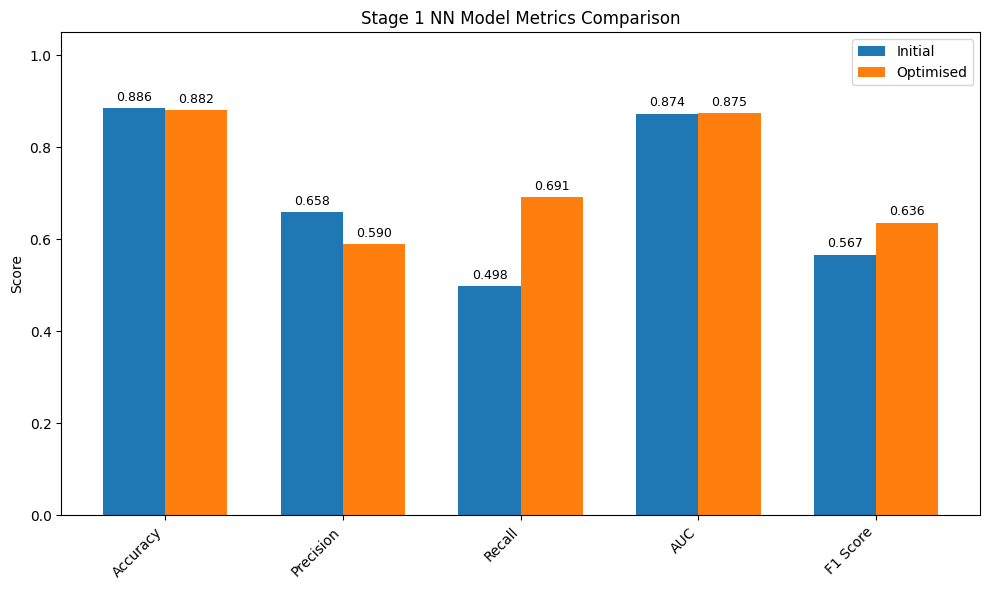

In [ ]:
plot_nn_metric_comparison_bar(nn_comparison_df_s1, stage_label='Stage 1')

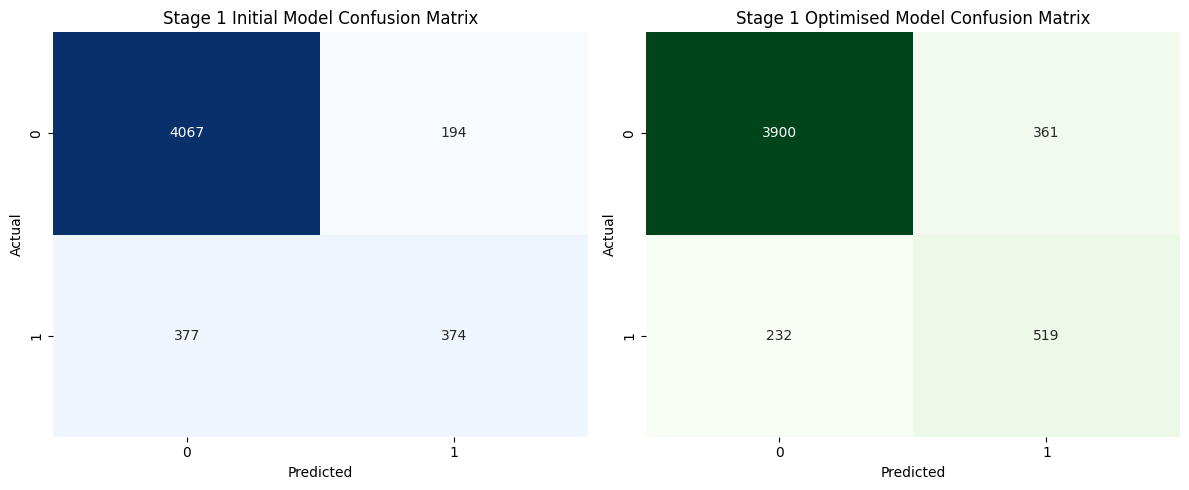

In [ ]:
plot_confusion_matrices(nn_comparison_df_s1, stage_label='Stage 1')

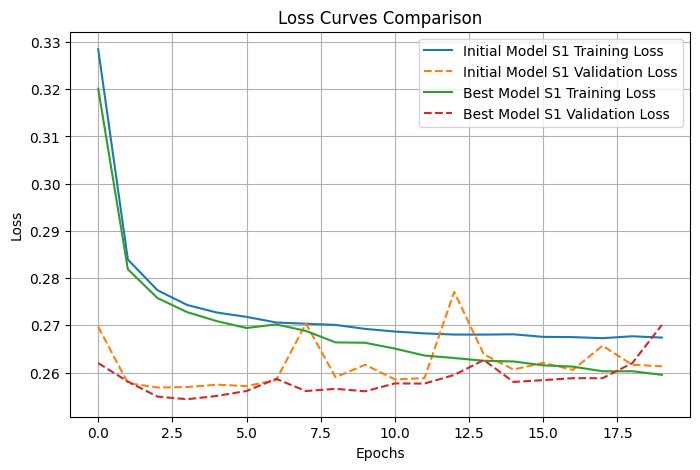

In [ ]:
plot_compare_loss_curves(initial_nn_history_s1, best_nn_history_s1, label1='Initial Model S1', label2='Best Model S1')

## XGB

In [ ]:
# --- COMMON FUNCTIONS (reused for all stages) ---

def build_and_train_xgb_model(
    X_train,
    y_train,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    eval_metric='logloss',
    verbosity=0,
    random_state=42
):
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        eval_metric=eval_metric,
        use_label_encoder=False,
        verbosity=verbosity,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    return model

def evaluate_xgb_model(y_true, y_pred, y_probs):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_probs)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {
        'Accuracy': acc,
        'Confusion Matrix': cm,
        'Precision': prec,
        'Recall': rec,
        'AUC': auc,
        'F1 Score': f1
    }

# Plot top 8 features + "Other"
def plot_top_features(model, feature_names, top_n=8):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]  # Sort descending

    # Top N features
    top_features = feature_names[sorted_idx][:top_n]
    top_importance = importance[sorted_idx][:top_n]

    # "Other" = sum of remaining
    other_importance = np.sum(importance[sorted_idx][top_n:])
    features_to_plot = list(top_features) + ["Other"]
    importances_to_plot = list(top_importance) + [other_importance]

    plt.figure(figsize=(20, 5))
    plt.barh(features_to_plot[::-1], importances_to_plot[::-1])
    plt.xlabel("Feature Importance")
    plt.title("Top Features (Others Grouped)")
    plt.tight_layout()
    plt.show()

# --- HYPERPARAMETER OPTIONS (common for all stages) ---
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2]
max_depths = [3, 5, 7]
n_estimators_list = [50, 100, 200]

In [ ]:
# Store each model and their results
xgb_models_s1 = []
xgb_results_s1 = []

# Grid search to find best parameter combination
for lr in learning_rates:
    for depth in max_depths:
        for n_est in n_estimators_list:
            print(f"[Stage 1] Training XGBoost model: lr={lr}, depth={depth}, n_estimators={n_est}")
            model = build_and_train_xgb_model(X1_train, y1_train, learning_rate=lr, max_depth=depth, n_estimators=n_est)

            # Predict for F1 score
            y_pred_probs = model.predict_proba(X1_test)[:, 1]
            y_pred = (y_pred_probs >= 0.5).astype(int)
            f1 = f1_score(y1_test, y_pred, zero_division=0)

            xgb_results_s1.append({
                'learning_rate': lr,
                'max_depth': depth,
                'n_estimators': n_est,
                'f1': f1
            })
            xgb_models_s1.append(model)

[Stage 1] Training XGBoost model: lr=0.01, depth=3, n_estimators=50
[Stage 1] Training XGBoost model: lr=0.01, depth=3, n_estimators=100
[Stage 1] Training XGBoost model: lr=0.01, depth=3, n_estimators=200
[Stage 1] Training XGBoost model: lr=0.01, depth=5, n_estimators=50
[Stage 1] Training XGBoost model: lr=0.01, depth=5, n_estimators=100
[Stage 1] Training XGBoost model: lr=0.01, depth=5, n_estimators=200
[Stage 1] Training XGBoost model: lr=0.01, depth=7, n_estimators=50
[Stage 1] Training XGBoost model: lr=0.01, depth=7, n_estimators=100
[Stage 1] Training XGBoost model: lr=0.01, depth=7, n_estimators=200
[Stage 1] Training XGBoost model: lr=0.05, depth=3, n_estimators=50
[Stage 1] Training XGBoost model: lr=0.05, depth=3, n_estimators=100
[Stage 1] Training XGBoost model: lr=0.05, depth=3, n_estimators=200
[Stage 1] Training XGBoost model: lr=0.05, depth=5, n_estimators=50
[Stage 1] Training XGBoost model: lr=0.05, depth=5, n_estimators=100
[Stage 1] Training XGBoost model: lr=0.

In [ ]:
# Define the best models parameters with highest f1 score
best_index_xgb_s1 = max(range(len(xgb_results_s1)), key=lambda i: xgb_results_s1[i]['f1'])
best_model_results_s1 = xgb_results_s1[best_index_xgb_s1]

# Extract the best trained model
best_xgb_model_s1 = xgb_models_s1[best_index_xgb_s1]

# Define initial baseline model
initial_xgb_model_s1 = xgb_models_s1[0]

# Convert predicted probabilities to binary class labels
y_pred_probs_initial_s1 = initial_xgb_model_s1.predict_proba(X1_test)[:, 1]
y_pred_initial_s1 = (y_pred_probs_initial_s1 >= 0.5).astype(int)

y_pred_probs_best_s1 = best_xgb_model_s1.predict_proba(X1_test)[:, 1]
y_pred_best_s1 = (y_pred_probs_best_s1 >= 0.5).astype(int)

# Compare models in df
xgb_comparison_df_s1 = pd.DataFrame({
    'Initial': evaluate_xgb_model(y1_test, y_pred_initial_s1, y_pred_probs_initial_s1),
    'Optimised': evaluate_xgb_model(y1_test, y_pred_best_s1, y_pred_probs_best_s1)
})

In [ ]:
# Best models params
best_model_results_s1

{'learning_rate': 0.15,
 'max_depth': 5,
 'n_estimators': 200,
 'f1': 0.6088888888888889}

In [ ]:
xgb_comparison_df_s1

,Initial,Optimised
Accuracy,0.85016,0.894653
Confusion Matrix,"[[4261, 0], [751, 0]]","[[4073, 188], [340, 411]]"
Precision,0.0,0.686144
Recall,0.0,0.54727
AUC,0.829922,0.886753
F1 Score,0.0,0.608889


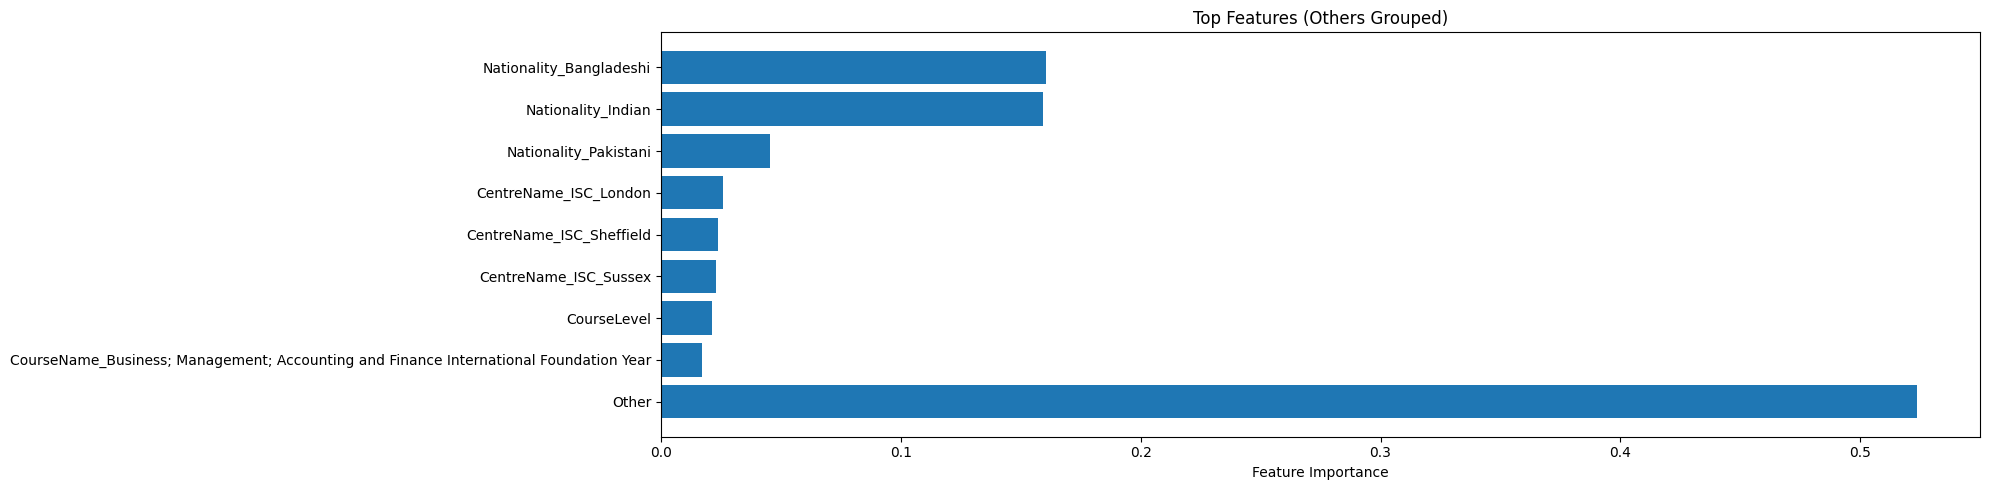

In [ ]:
plot_top_features(best_xgb_model_s1, np.array(X1_train.columns))

# Stage 2

## PreProcess

In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=1vy1JFQZva3lhMJQV69C43AB1NTM4W-DZ"
df2 = pd.read_csv(file_url)

In [ ]:
# View df
print("Shape:", df2.shape)
df2.head()

Shape: (25059, 18)


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
# Drop 'LearnerCode'
df2.drop(columns=['LearnerCode'], inplace=True)

In [ ]:
# Convert DOB to Age
df2['DateofBirth'] = pd.to_datetime(df2['DateofBirth'], dayfirst=True, errors='coerce')
df2['Age'] = (pd.to_datetime("today") - df2['DateofBirth']).dt.days // 365
df2.drop(columns=['DateofBirth'], inplace=True)

In [ ]:
# View unique values
print("Unique counts per column:")
print(df2.nunique())

Unique counts per column:
CentreName                    19
BookingType                    2
LeadSource                     7
DiscountType                  11
Gender                         2
Nationality                  151
HomeState                   2448
HomeCity                    5881
CourseLevel                    4
CourseName                   172
IsFirstIntake                  2
CompletedCourse                2
ProgressionDegree           2616
ProgressionUniversity         40
AuthorisedAbsenceCount       190
UnauthorisedAbsenceCount     258
Age                           38
dtype: int64


In [ ]:
# Drop columns with more than 200 unique values except 'UnauthorisedAbsenceCount'
high_card_cols = [
    col for col in df2.columns
    if df2[col].nunique() > 200 and col != 'UnauthorisedAbsenceCount'
]

df2.drop(columns=high_card_cols, inplace=True)

print("Dropped columns:", high_card_cols)

Dropped columns: ['HomeState', 'HomeCity', 'ProgressionDegree']


In [ ]:
# Drop columns from df2 with >50% missing values
missing_percent = df2.isnull().mean() * 100
print(missing_percent)

cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
df2.drop(columns=cols_to_drop, inplace=True)

print("\nDropped columns with >50% missing:", cols_to_drop)

CentreName                   0.000000
BookingType                  0.000000
LeadSource                   0.000000
DiscountType                69.691528
Gender                       0.000000
Nationality                  0.000000
CourseLevel                  0.000000
CourseName                   0.000000
IsFirstIntake                0.000000
CompletedCourse              0.000000
ProgressionUniversity        0.000000
AuthorisedAbsenceCount       0.830041
UnauthorisedAbsenceCount     0.830041
Age                          0.000000
dtype: float64

Dropped columns with >50% missing: ['DiscountType']


In [ ]:
# Delete remaining rows with missing values
df2 = df2.dropna(subset=['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'])
missing_percent = df2.isnull().mean() * 100
print(missing_percent)

CentreName                  0.0
BookingType                 0.0
LeadSource                  0.0
Gender                      0.0
Nationality                 0.0
CourseLevel                 0.0
CourseName                  0.0
IsFirstIntake               0.0
CompletedCourse             0.0
ProgressionUniversity       0.0
AuthorisedAbsenceCount      0.0
UnauthorisedAbsenceCount    0.0
Age                         0.0
dtype: float64


In [ ]:
# Binary encode target variable (dropout=1)
df2['Dropout'] = df2['CompletedCourse'].map({'Yes': 0, 'No': 1})
df2.drop(columns=['CompletedCourse'], inplace=True)

In [ ]:
# Ordinal encode ordinal data
course_level_order = ['Foundation', 'International Year One', 'International Year Two', 'Pre-Masters']

df2['CourseLevel'] = pd.Categorical(df2['CourseLevel'], categories=course_level_order, ordered=True)
df2['CourseLevel'] = df2['CourseLevel'].cat.codes

In [ ]:
# One hot encode categorical data
categorical_cols = df2.select_dtypes(include='object').columns
df2 = pd.get_dummies(df2, columns=categorical_cols, drop_first=True)

In [ ]:
# Convert all boolean columns to int (0/1)
df2 = df2.astype({col: 'int' for col in df2.select_dtypes(include='bool').columns})

In [ ]:
df2.head()

,CourseLevel,IsFirstIntake,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age,Dropout,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
1,0,0,93.0,5.0,27,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,0,92.0,6.0,25,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2,1,67.0,15.0,26,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,2,1,67.0,3.0,25,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,0,0,29.0,18.0,23,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


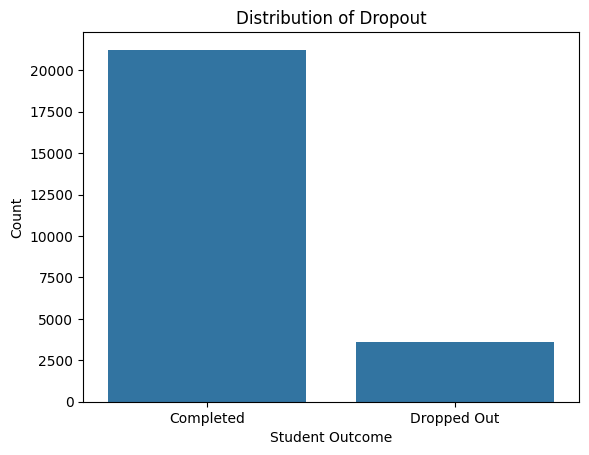

In [ ]:
sns.countplot(data=df2, x='Dropout')
plt.title('Distribution of Dropout')
plt.xticks([0, 1], ['Completed', 'Dropped Out'])
plt.xlabel('Student Outcome')
plt.ylabel('Count')
plt.show()

In [ ]:
# Stage 2 features and target
X2 = df2.drop(columns=['Dropout'])  # replace with your actual target column name
y2 = df2['Dropout']

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2,
    test_size=0.2,
    random_state=42,
    stratify=y2
)

## NN

In [ ]:
# Store each NN model's results and history
nn_results_s2 = []
nn_histories_s2 = []

# Grid search to find best parameter combination
for activation in activations:
    for n_layers in n_layers_list:
        for n_neurons in n_neurons_list:
            for optimizer in optimizers:
                print(f"Stage 2 NN Training: {activation=}, {n_layers=}, {n_neurons=}, {optimizer=}")
                model, history = build_and_train_nn_model(
                    X2_train, y2_train,
                    n_layers=n_layers,
                    n_neurons=n_neurons,
                    activation=activation,
                    optimizer=optimizer
                )

                # Predictions for F1 score
                y_pred_probs = model.predict(X2_test)
                y_pred = (y_pred_probs >= 0.5).astype(int)
                f1 = f1_score(y2_test, y_pred, zero_division=0)

                # Store parameters and metrics in results
                nn_results_s2.append({
                    'activation': activation,
                    'n_layers': n_layers,
                    'n_neurons': n_neurons,
                    'optimizer': optimizer,
                    'model': model,
                    'f1': f1
                })
                nn_histories_s2.append(history)

Stage 2 NN Training: activation='relu', n_layers=1, n_neurons=16, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 2 NN Training: activation='relu', n_layers=1, n_neurons=16, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 2 NN Training: activation='relu', n_layers=1, n_neurons=32, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stage 2 NN Training: activation='relu', n_layers=1, n_neurons=32, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 2 NN Training: activation='relu', n_layers=1, n_neurons=64, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 2 NN Training: activation='relu', n_layers=1, n_neurons=64, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 2 NN Training: activation='relu', n_layers=2, n_neurons=16, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 2 NN Training: activation='relu', n_layers=2, n_neurons=16, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

In [ ]:
# Define the best NN model's parameters with highest f1 score
best_index_nn_s2 = max(range(len(nn_results_s2)), key=lambda i: nn_results_s2[i]['f1'])
best_nn_model_results_s2 = nn_results_s2[best_index_nn_s2]

# Extract the best trained NN model and its training history
best_nn_model_s2 = best_nn_model_results_s2['model']
best_nn_history_s2 = nn_histories_s2[best_index_nn_s2]

# Define initial baseline NN model
initial_nn_model_s2 = nn_results_s2[0]['model']
initial_nn_history_s2 = nn_histories_s2[0]

# Convert predicted probabilities to binary class labels
y_pred_probs_initial_nn_s2 = initial_nn_model_s2.predict(X2_test)
y_pred_initial_nn_s2 = (y_pred_probs_initial_nn_s2 >= 0.5).astype(int)  # 0.5 threshold

y_pred_probs_best_nn_s2 = best_nn_model_s2.predict(X2_test)
y_pred_best_nn_s2 = (y_pred_probs_best_nn_s2 >= 0.5).astype(int)  # 0.5 threshold

# Compare NN models in df
nn_comparison_df_s2 = pd.DataFrame({
    'Initial': evaluate_model(y2_test, y_pred_initial_nn_s2, y_pred_probs_initial_nn_s2),
    'Optimised': evaluate_model(y2_test, y_pred_best_nn_s2, y_pred_probs_best_nn_s2)
})

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
print(best_nn_model_results_s2)

{'activation': 'tanh', 'n_layers': 2, 'n_neurons': 64, 'optimizer': 'adam', 'model': <Sequential name=sequential_64, built=True>, 'f1': 0.6634681288553804}


In [ ]:
nn_comparison_df_s2

,Initial,Optimised
Accuracy,0.902635,0.901227
Confusion Matrix,"[[4126, 123], [361, 361]]","[[3996, 253], [238, 484]]"
Precision,0.745868,0.656716
Recall,0.5,0.67036
AUC,0.900425,0.903939
F1 Score,0.598673,0.663468


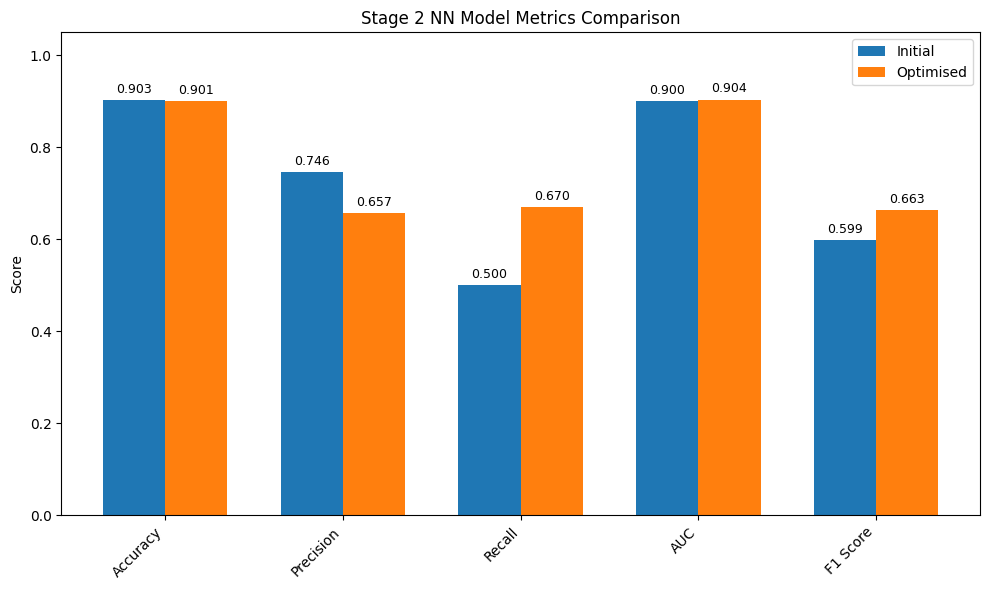

In [ ]:
plot_nn_metric_comparison_bar(nn_comparison_df_s2, stage_label='Stage 2')

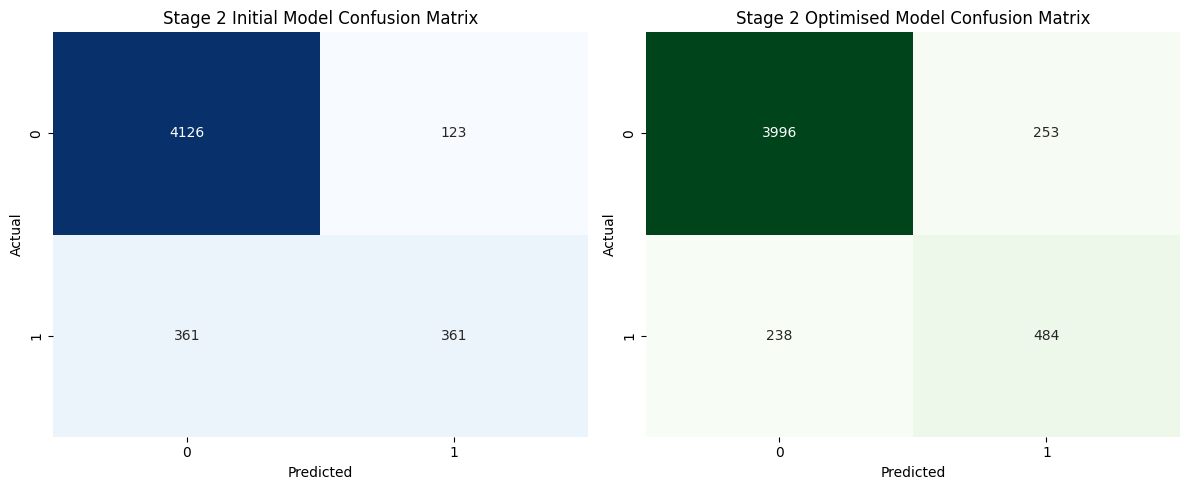

In [ ]:
plot_confusion_matrices(nn_comparison_df_s2, stage_label='Stage 2')

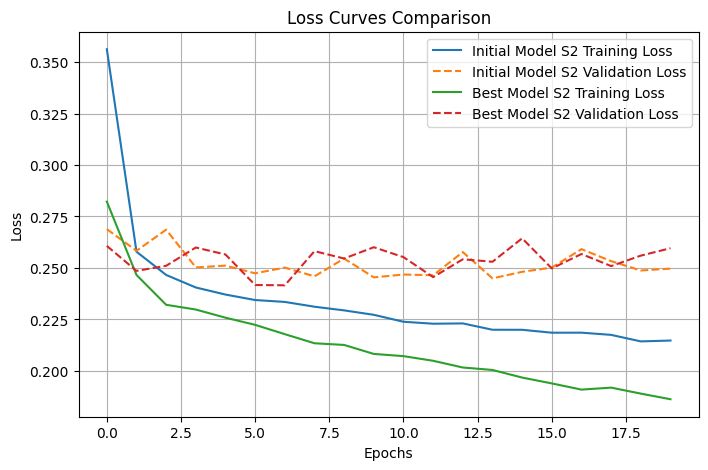

In [ ]:
plot_compare_loss_curves(initial_nn_history_s2, best_nn_history_s2, label1='Initial Model S2', label2='Best Model S2')

## XGB

In [ ]:
# Store each model and their results
xgb_models_s2 = []
xgb_results_s2 = []

# Grid search to find best parameter combination
for lr in learning_rates:
    for depth in max_depths:
        for n_est in n_estimators_list:
            print(f"[Stage 2] Training XGBoost model: lr={lr}, depth={depth}, n_estimators={n_est}")
            model = build_and_train_xgb_model(X2_train, y2_train, learning_rate=lr, max_depth=depth, n_estimators=n_est)

            # Predict for F1 score
            y_pred_probs = model.predict_proba(X2_test)[:, 1]
            y_pred = (y_pred_probs >= 0.5).astype(int)
            f1 = f1_score(y2_test, y_pred, zero_division=0)

            xgb_results_s2.append({
                'learning_rate': lr,
                'max_depth': depth,
                'n_estimators': n_est,
                'f1': f1
            })
            xgb_models_s2.append(model)

[Stage 2] Training XGBoost model: lr=0.01, depth=3, n_estimators=50
[Stage 2] Training XGBoost model: lr=0.01, depth=3, n_estimators=100
[Stage 2] Training XGBoost model: lr=0.01, depth=3, n_estimators=200
[Stage 2] Training XGBoost model: lr=0.01, depth=5, n_estimators=50
[Stage 2] Training XGBoost model: lr=0.01, depth=5, n_estimators=100
[Stage 2] Training XGBoost model: lr=0.01, depth=5, n_estimators=200
[Stage 2] Training XGBoost model: lr=0.01, depth=7, n_estimators=50
[Stage 2] Training XGBoost model: lr=0.01, depth=7, n_estimators=100
[Stage 2] Training XGBoost model: lr=0.01, depth=7, n_estimators=200
[Stage 2] Training XGBoost model: lr=0.05, depth=3, n_estimators=50
[Stage 2] Training XGBoost model: lr=0.05, depth=3, n_estimators=100
[Stage 2] Training XGBoost model: lr=0.05, depth=3, n_estimators=200
[Stage 2] Training XGBoost model: lr=0.05, depth=5, n_estimators=50
[Stage 2] Training XGBoost model: lr=0.05, depth=5, n_estimators=100
[Stage 2] Training XGBoost model: lr=0.

In [ ]:
# Define the best models parameters with highest f1 score
best_index_xgb_s2 = max(range(len(xgb_results_s2)), key=lambda i: xgb_results_s2[i]['f1'])
best_model_results_s2 = xgb_results_s2[best_index_xgb_s2]

# Extract the best trained model
best_xgb_model_s2 = xgb_models_s2[best_index_xgb_s2]

# Define initial baseline model
initial_xgb_model_s2 = xgb_models_s2[0]

# Convert predicted probabilities to binary class labels
y_pred_probs_initial_s2 = initial_xgb_model_s2.predict_proba(X2_test)[:, 1]
y_pred_initial_s2 = (y_pred_probs_initial_s2 >= 0.5).astype(int)

y_pred_probs_best_s2 = best_xgb_model_s2.predict_proba(X2_test)[:, 1]
y_pred_best_s2 = (y_pred_probs_best_s2 >= 0.5).astype(int)

# Compare models in df
xgb_comparison_df_s2 = pd.DataFrame({
    'Initial': evaluate_xgb_model(y2_test, y_pred_initial_s2, y_pred_probs_initial_s2),
    'Optimised': evaluate_xgb_model(y2_test, y_pred_best_s2, y_pred_probs_best_s2)
})

In [ ]:
# Best models params
best_model_results_s2

{'learning_rate': 0.15,
 'max_depth': 7,
 'n_estimators': 50,
 'f1': 0.6707978311386522}

In [ ]:
xgb_comparison_df_s2

,Initial,Optimised
Accuracy,0.854758,0.914504
Confusion Matrix,"[[4249, 0], [722, 0]]","[[4113, 136], [289, 433]]"
Precision,0.0,0.760984
Recall,0.0,0.599723
AUC,0.862621,0.914013
F1 Score,0.0,0.670798


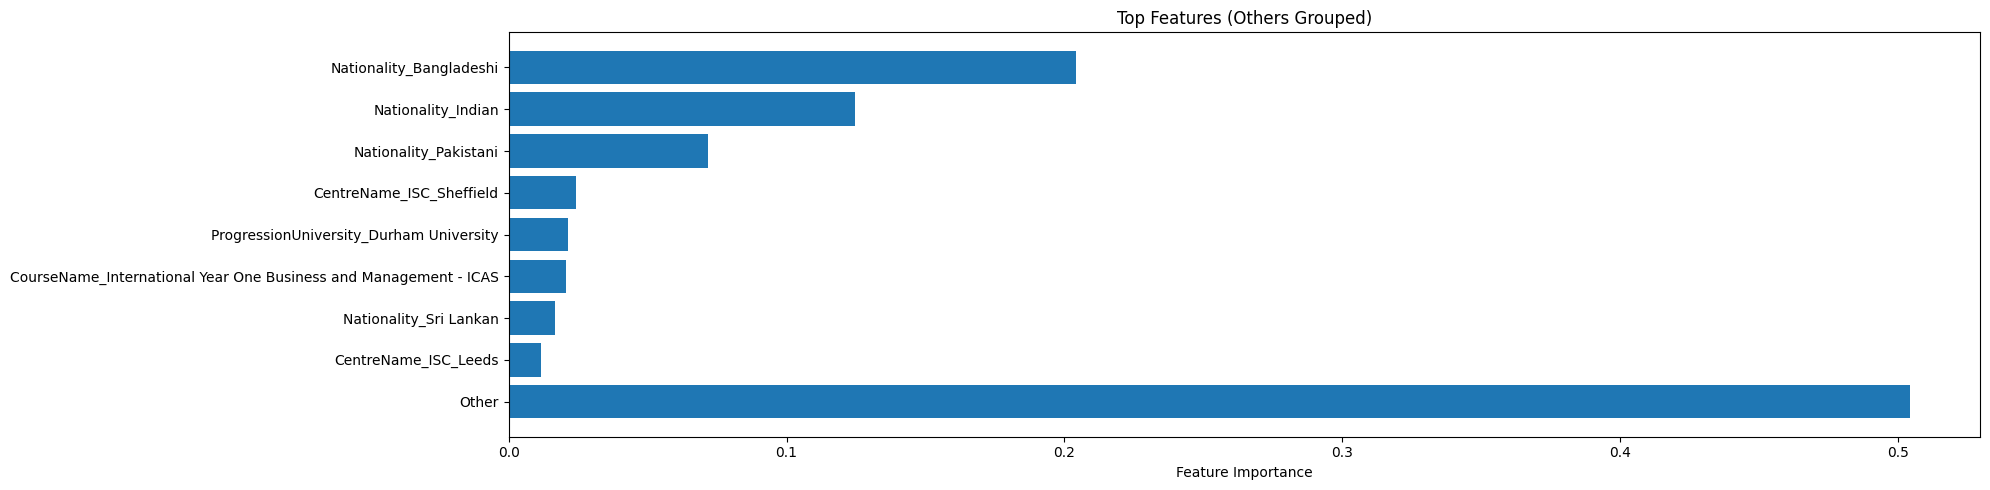

In [ ]:
plot_top_features(best_xgb_model_s2, np.array(X2_train.columns))

## Comparisons

# Initial NN1 vs Initial NN2

**Accuracy:** NN2: 0.9026 → NN1: 0.8861  
**Precision:** NN2: 0.7459 → NN1: 0.6585  
**Recall:** NN2: 0.5000 → NN1: 0.4980  
**AUC:** NN2: 0.9004 → NN1: 0.8735

## Reason for Differences

- Stage 2 adds absence features, providing extra behavioural information for the network.  
- Recall increases slightly (0.5000 vs 0.4980), indicating NN2 is more willing to predict positives when absence patterns match dropout profiles.  
- Precision also rises, showing the added features improve positive prediction accuracy.  
- Gains are modest compared to later datasets, suggesting absence features help but are not as dominant.

# Initial XGB1 vs Initial XGB2

**Accuracy:** XGB2: 0.8548 → XGB1: 0.8502  
**Precision:** XGB2: 0.0000 → XGB1: 0.0000 (unchanged due to class prediction issue)  
**Recall:** XGB2: 0.0000 → XGB1: 0.0000 (unchanged for same reason)  
**AUC:** XGB2: 0.8626 → XGB1: 0.8299

## Reason for Slight Outperformance

- AUC improvement shows probability estimates improved with absence features, despite zero positive predictions at the reported threshold.  
- Tree models can exploit absence counts as split points, but poor initial thresholding limited observable recall and precision gains.

# Initial NN2 vs Optimised NN2

**Accuracy:** Optimised: 0.9012 → Initial: 0.9026  
**Precision:** Optimised: 0.6567 → Initial: 0.7459  
**Recall:** Optimised: 0.6704 → Initial: 0.5000  
**AUC:** Optimised: 0.9039 → Initial: 0.9004

## Observations

- Optimisation traded precision for recall.  
- The model became more aggressive in predicting positives, capturing more true positives but producing more false positives.

# Initial XGB2 vs Optimised XGB2

**Accuracy:** Optimised: 0.9125 → Initial: 0.8548  
**Precision:** Optimised: 0.7487 → Initial: 0.0000  
**Recall:** Optimised: 0.5983 → Initial: 0.0000  
**AUC:** Optimised: 0.9121 → Initial: 0.8626

## Observations

- Optimisation corrected thresholding issues.  
- Absence features were effectively leveraged, producing large gains in recall and precision as well as improved accuracy.

# Stage 3

## PreProcess

In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=18oyu-RQotQN6jaibsLBoPdqQJbj_cV2-"
df3 = pd.read_csv(file_url)

In [ ]:
# View df
print("Shape:", df3.shape)
df3.head()

Shape: (25059, 21)


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN


In [ ]:
# Convert DOB to Age
df3['DateofBirth'] = pd.to_datetime(df3['DateofBirth'], dayfirst=True, errors='coerce')
df3['Age'] = (pd.to_datetime("today") - df3['DateofBirth']).dt.days // 365
df3.drop(columns=['DateofBirth'], inplace=True)

In [ ]:
# View unique values
print("Unique counts per column:")
print(df3.nunique())

Unique counts per column:
CentreName                     19
LearnerCode                 24877
BookingType                     2
LeadSource                      7
DiscountType                   11
Gender                          2
Nationality                   151
HomeState                    2448
HomeCity                     5881
CourseLevel                     4
CourseName                    172
IsFirstIntake                   2
CompletedCourse                 2
AssessedModules                12
PassedModules                  12
FailedModules                  11
ProgressionDegree            2616
ProgressionUniversity          40
AuthorisedAbsenceCount        190
UnauthorisedAbsenceCount      258
Age                            38
dtype: int64


In [ ]:
# Drop columns with more than 200 unique values except 'UnauthorisedAbsenceCount'
high_card_cols = [
    col for col in df3.columns
    if df3[col].nunique() > 200 and col != 'UnauthorisedAbsenceCount'
]

df3.drop(columns=high_card_cols, inplace=True)

print("Dropped columns:", high_card_cols)

Dropped columns: ['LearnerCode', 'HomeState', 'HomeCity', 'ProgressionDegree']


In [ ]:
# Drop columns from df3 with >50% missing values
missing_percent = df3.isnull().mean() * 100
print(missing_percent)

cols_to_drop = missing_percent[missing_percent > 50].index.tolist()
df3.drop(columns=cols_to_drop, inplace=True)

print("\nDropped columns with >50% missing:", cols_to_drop)

CentreName                   0.000000
BookingType                  0.000000
LeadSource                   0.000000
DiscountType                69.691528
Gender                       0.000000
Nationality                  0.000000
CourseLevel                  0.000000
CourseName                   0.000000
IsFirstIntake                0.000000
CompletedCourse              0.000000
AssessedModules              8.902989
PassedModules                8.902989
FailedModules                8.902989
ProgressionUniversity        0.000000
AuthorisedAbsenceCount       0.830041
UnauthorisedAbsenceCount     0.830041
Age                          0.000000
dtype: float64

Dropped columns with >50% missing: ['DiscountType']


In [ ]:
# Delete remaining rows with missing values
df3 = df3.dropna(subset=['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'])
missing_percent = df3.isnull().mean() * 100
print(missing_percent)

CentreName                  0.000000
BookingType                 0.000000
LeadSource                  0.000000
Gender                      0.000000
Nationality                 0.000000
CourseLevel                 0.000000
CourseName                  0.000000
IsFirstIntake               0.000000
CompletedCourse             0.000000
AssessedModules             8.458412
PassedModules               8.458412
FailedModules               8.458412
ProgressionUniversity       0.000000
AuthorisedAbsenceCount      0.000000
UnauthorisedAbsenceCount    0.000000
Age                         0.000000
dtype: float64


In [ ]:
df3.describe()

,AssessedModules,PassedModules,FailedModules,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
count,22749.000000,22749.000000,22749.000000,24851.000000,24851.000000,24851.000000
mean,6.097675,5.589564,0.508110,15.120639,40.491892,24.621504
std,1.806064,2.358803,1.306538,28.918253,39.029384,3.165965
min,1.000000,0.000000,0.000000,0.000000,0.000000,19.000000
25%,4.000000,4.000000,0.000000,0.000000,12.000000,22.000000
50%,6.000000,6.000000,0.000000,1.000000,29.000000,24.000000
75%,7.000000,7.000000,0.000000,15.000000,56.000000,26.000000
max,12.000000,11.000000,10.000000,292.000000,343.000000,63.000000


In [ ]:
cols_to_impute = ['AssessedModules', 'PassedModules', 'FailedModules']

# Impute each with its median
for col in cols_to_impute:
    median_val = int(df3[col].median())
    df3[col] = df3[col].fillna(median_val)

In [ ]:
missing_percent = df3.isnull().mean() * 100
missing_percent.head()

,0
CentreName,0.0
BookingType,0.0
LeadSource,0.0
Gender,0.0
Nationality,0.0


In [ ]:
# Binary encode target variable (dropout=1)
df3['Dropout'] = df3['CompletedCourse'].map({'Yes': 0, 'No': 1})
df3.drop(columns=['CompletedCourse'], inplace=True)

In [ ]:
# Ordinal encode ordinal data
course_level_order = ['Foundation', 'International Year One', 'International Year Two', 'Pre-Masters']

df3['CourseLevel'] = pd.Categorical(df3['CourseLevel'], categories=course_level_order, ordered=True)
df3['CourseLevel'] = df3['CourseLevel'].cat.codes

In [ ]:
# One hot encode categorical data
categorical_cols = df3.select_dtypes(include='object').columns
df3 = pd.get_dummies(df3, columns=categorical_cols, drop_first=True)

In [ ]:
# Convert all boolean columns to int (0/1)
df3 = df3.astype({col: 'int' for col in df3.select_dtypes(include='bool').columns})

In [ ]:
df3.head()

,CourseLevel,IsFirstIntake,AssessedModules,PassedModules,FailedModules,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age,Dropout,CentreName_ISC_Cardiff,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
1,0,0,7.0,7.0,0.0,93.0,5.0,27,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2,0,8.0,8.0,0.0,92.0,6.0,25,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2,1,8.0,8.0,0.0,67.0,15.0,26,0,0,...,0,1,0,0,0,0,0,0,0,0
5,2,1,8.0,8.0,0.0,67.0,3.0,25,0,0,...,0,1,0,0,0,0,0,0,0,0
6,0,0,6.0,6.0,0.0,29.0,18.0,23,1,0,...,0,1,0,0,0,0,0,0,0,0


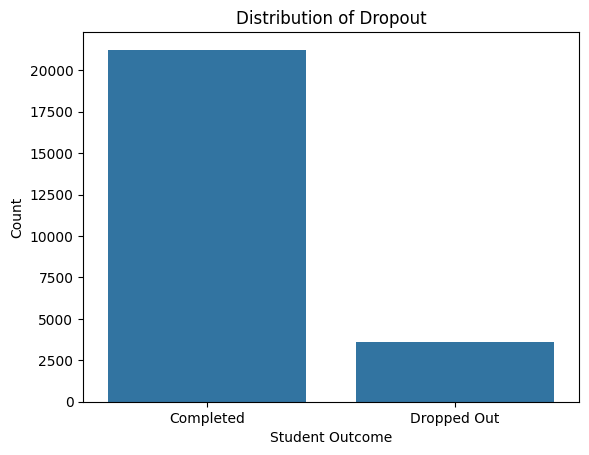

In [ ]:
sns.countplot(data=df3, x='Dropout')
plt.title('Distribution of Dropout')
plt.xticks([0, 1], ['Completed', 'Dropped Out'])
plt.xlabel('Student Outcome')
plt.ylabel('Count')
plt.show()

In [ ]:
# Stage 3 features and target
X3 = df3.drop(columns=['Dropout'])  # replace with your actual target column name
y3 = df3['Dropout']

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3,
    test_size=0.2,
    random_state=42,
    stratify=y3
)

## NN

In [ ]:
# Store each NN model's results and history
nn_results_s3 = []
nn_histories_s3 = []

# Grid search to find best parameter combination
for activation in activations:
    for n_layers in n_layers_list:
        for n_neurons in n_neurons_list:
            for optimizer in optimizers:
                print(f"Stage 3 NN Training: {activation=}, {n_layers=}, {n_neurons=}, {optimizer=}")
                model, history = build_and_train_nn_model(
                    X3_train, y3_train,
                    n_layers=n_layers,
                    n_neurons=n_neurons,
                    activation=activation,
                    optimizer=optimizer
                )

                # Predictions for F1 score
                y_pred_probs = model.predict(X3_test)
                y_pred = (y_pred_probs >= 0.5).astype(int)
                f1 = f1_score(y3_test, y_pred, zero_division=0)

                # Store parameters and metrics in results
                nn_results_s3.append({
                    'activation': activation,
                    'n_layers': n_layers,
                    'n_neurons': n_neurons,
                    'optimizer': optimizer,
                    'model': model,
                    'f1': f1
                })
                nn_histories_s3.append(history)

Stage 3 NN Training: activation='relu', n_layers=1, n_neurons=16, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 3 NN Training: activation='relu', n_layers=1, n_neurons=16, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Stage 3 NN Training: activation='relu', n_layers=1, n_neurons=32, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 3 NN Training: activation='relu', n_layers=1, n_neurons=32, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 3 NN Training: activation='relu', n_layers=1, n_neurons=64, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 3 NN Training: activation='relu', n_layers=1, n_neurons=64, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Stage 3 NN Training: activation='relu', n_layers=2, n_neurons=16, optimizer='adam'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Stage 3 NN Training: activation='relu', n_layers=2, n_neurons=16, optimizer='rmsprop'
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

In [ ]:
# Define the best NN model's parameters with highest f1 score
best_index_nn_s3 = max(range(len(nn_results_s3)), key=lambda i: nn_results_s3[i]['f1'])
best_nn_model_results_s3 = nn_results_s3[best_index_nn_s3]

# Extract the best trained NN model and its training history
best_nn_model_s3 = best_nn_model_results_s3['model']
best_nn_history_s3 = nn_histories_s3[best_index_nn_s3]

# Define initial baseline NN model
initial_nn_model_s3 = nn_results_s3[0]['model']
initial_nn_history_s3 = nn_histories_s3[0]

# Convert predicted probabilities to binary class labels
y_pred_probs_initial_nn_s3 = initial_nn_model_s3.predict(X3_test)
y_pred_initial_nn_s3 = (y_pred_probs_initial_nn_s3 >= 0.5).astype(int)  # 0.5 threshold

y_pred_probs_best_nn_s3 = best_nn_model_s3.predict(X3_test)
y_pred_best_nn_s3 = (y_pred_probs_best_nn_s3 >= 0.5).astype(int)  # 0.5 threshold

# Compare NN models in df
nn_comparison_df_s3 = pd.DataFrame({
    'Initial': evaluate_model(y3_test, y_pred_initial_nn_s3, y_pred_probs_initial_nn_s3),
    'Optimised': evaluate_model(y3_test, y_pred_best_nn_s3, y_pred_probs_best_nn_s3)
})

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
print(best_nn_model_results_s3)

{'activation': 'tanh', 'n_layers': 3, 'n_neurons': 64, 'optimizer': 'adam', 'model': <Sequential name=sequential_106, built=True>, 'f1': 0.865826538176427}


In [ ]:
nn_comparison_df_s3

,Initial,Optimised
Accuracy,0.941662,0.963589
Confusion Matrix,"[[4145, 104], [186, 536]]","[[4206, 43], [138, 584]]"
Precision,0.8375,0.931419
Recall,0.742382,0.808864
AUC,0.950094,0.970583
F1 Score,0.787078,0.865827


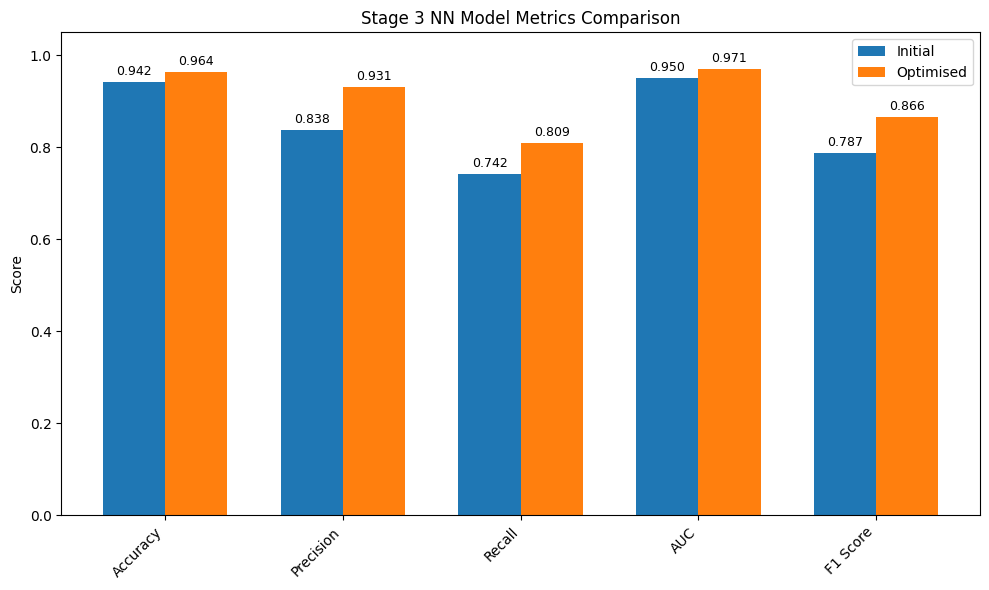

In [ ]:
plot_nn_metric_comparison_bar(nn_comparison_df_s3, stage_label='Stage 3')

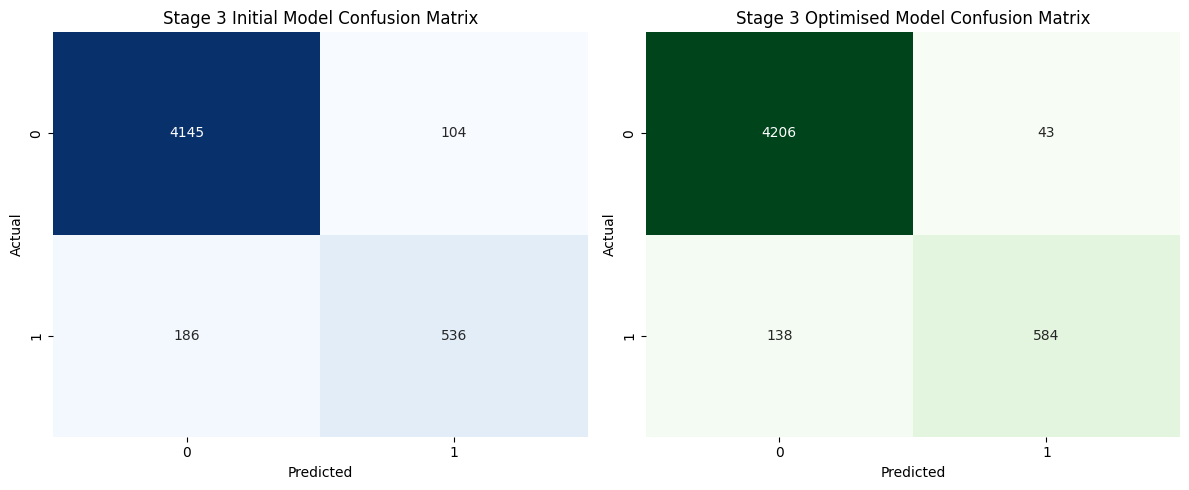

In [ ]:
plot_confusion_matrices(nn_comparison_df_s3, stage_label='Stage 3')

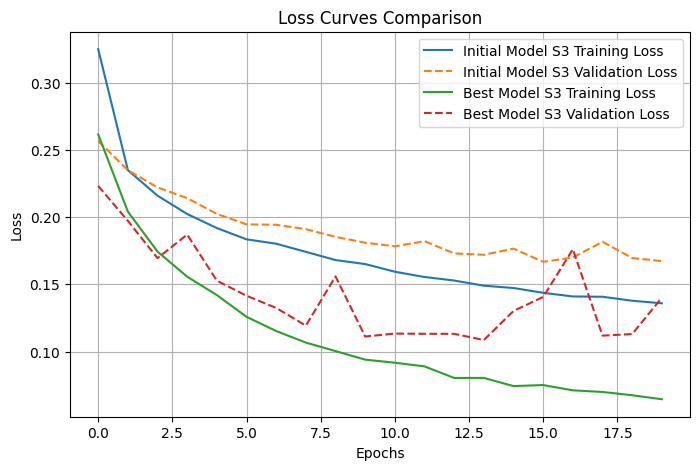

In [ ]:
plot_compare_loss_curves(initial_nn_history_s3, best_nn_history_s3, label1='Initial Model S3', label2='Best Model S3')

## XGB

In [ ]:
# Store each model and their results
xgb_models_s3 = []
xgb_results_s3 = []

# Grid search to find best parameter combination
for lr in learning_rates:
    for depth in max_depths:
        for n_est in n_estimators_list:
            print(f"[Stage 3] Training XGBoost model: lr={lr}, depth={depth}, n_estimators={n_est}")
            model = build_and_train_xgb_model(X3_train, y3_train, learning_rate=lr, max_depth=depth, n_estimators=n_est)

            # Predict for F1 score
            y_pred_probs = model.predict_proba(X3_test)[:, 1]
            y_pred = (y_pred_probs >= 0.5).astype(int)
            f1 = f1_score(y3_test, y_pred, zero_division=0)

            xgb_results_s3.append({
                'learning_rate': lr,
                'max_depth': depth,
                'n_estimators': n_est,
                'f1': f1
            })
            xgb_models_s3.append(model)

[Stage 3] Training XGBoost model: lr=0.01, depth=3, n_estimators=50
[Stage 3] Training XGBoost model: lr=0.01, depth=3, n_estimators=100
[Stage 3] Training XGBoost model: lr=0.01, depth=3, n_estimators=200
[Stage 3] Training XGBoost model: lr=0.01, depth=5, n_estimators=50
[Stage 3] Training XGBoost model: lr=0.01, depth=5, n_estimators=100
[Stage 3] Training XGBoost model: lr=0.01, depth=5, n_estimators=200
[Stage 3] Training XGBoost model: lr=0.01, depth=7, n_estimators=50
[Stage 3] Training XGBoost model: lr=0.01, depth=7, n_estimators=100
[Stage 3] Training XGBoost model: lr=0.01, depth=7, n_estimators=200
[Stage 3] Training XGBoost model: lr=0.05, depth=3, n_estimators=50
[Stage 3] Training XGBoost model: lr=0.05, depth=3, n_estimators=100
[Stage 3] Training XGBoost model: lr=0.05, depth=3, n_estimators=200
[Stage 3] Training XGBoost model: lr=0.05, depth=5, n_estimators=50
[Stage 3] Training XGBoost model: lr=0.05, depth=5, n_estimators=100
[Stage 3] Training XGBoost model: lr=0.

In [ ]:
# Define the best models parameters with highest f1 score
best_index_xgb_s3 = max(range(len(xgb_results_s3)), key=lambda i: xgb_results_s3[i]['f1'])
best_model_results_s3 = xgb_results_s3[best_index_xgb_s3]

# Extract the best trained model
best_xgb_model_s3 = xgb_models_s3[best_index_xgb_s3]

# Define initial baseline model
initial_xgb_model_s3 = xgb_models_s3[0]

# Convert predicted probabilities to binary class labels
y_pred_probs_initial_s3 = initial_xgb_model_s3.predict_proba(X3_test)[:, 1]
y_pred_initial_s3 = (y_pred_probs_initial_s3 >= 0.5).astype(int)

y_pred_probs_best_s3 = best_xgb_model_s3.predict_proba(X3_test)[:, 1]
y_pred_best_s3 = (y_pred_probs_best_s3 >= 0.5).astype(int)

# Compare models in df
xgb_comparison_df_s3 = pd.DataFrame({
    'Initial': evaluate_xgb_model(y3_test, y_pred_initial_s3, y_pred_probs_initial_s3),
    'Optimised': evaluate_xgb_model(y3_test, y_pred_best_s3, y_pred_probs_best_s3)
})

print(best_model_results_s3)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'f1': 0.9205903021784961}


In [ ]:
# Best models params
best_model_results_s3

{'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 200,
 'f1': 0.9205903021784961}

In [ ]:
xgb_comparison_df_s3

,Initial,Optimised
Accuracy,0.854758,0.977268
Confusion Matrix,"[[4249, 0], [722, 0]]","[[4203, 46], [67, 655]]"
Precision,0.0,0.934379
Recall,0.0,0.907202
AUC,0.940369,0.993119
F1 Score,0.0,0.92059


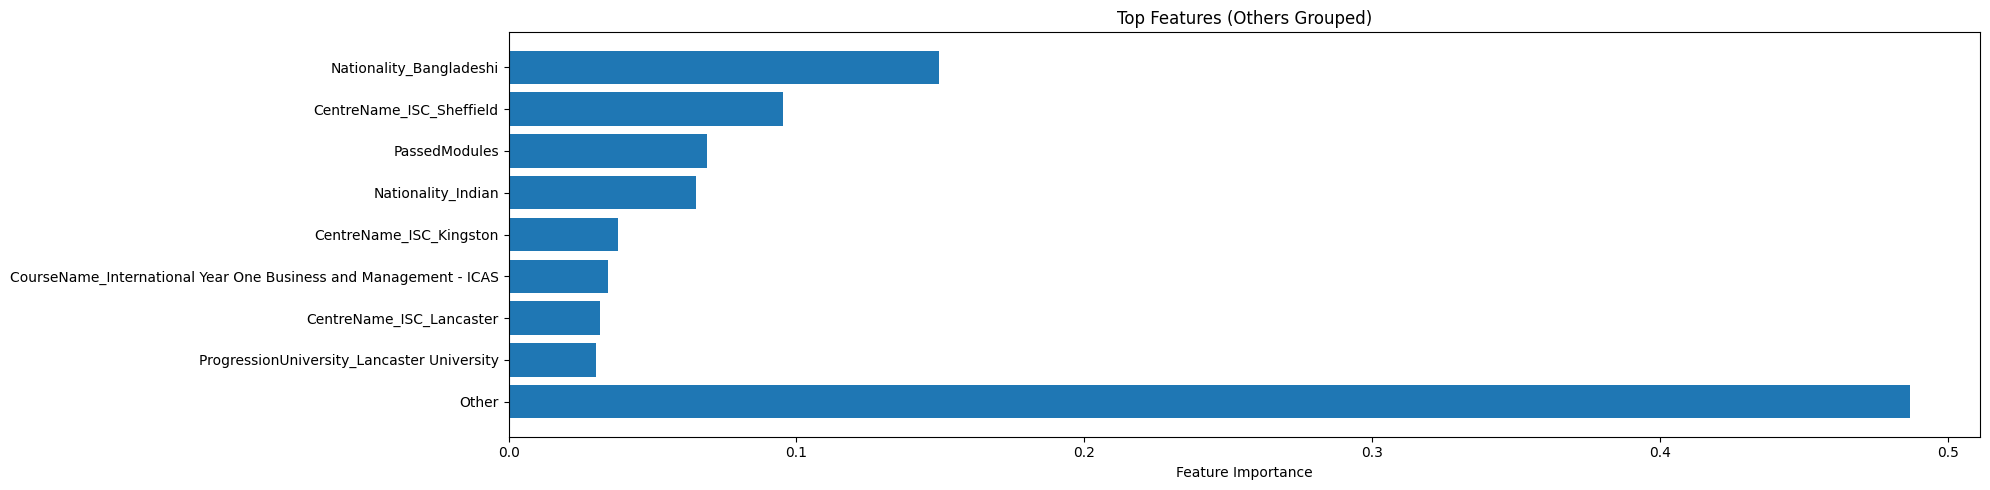

In [ ]:
plot_top_features(best_xgb_model_s3, np.array(X3_train.columns))

## Comparisons

# Optimised NN2 vs Optimised NN3

**Accuracy:** 0.9012 → 0.9636 (+0.0624)  
**Precision:** 0.6567 → 0.9314 (+0.2747)  
**Recall:** 0.6704 → 0.8089 (+0.1385)  
**AUC:** 0.9039 → 0.9706 (+0.0667)

## Reason for Gains

- Stage 3 includes module-level academic performance indicators (assessed, passed, failed modules), which carry high predictive weight.  
- The network captures non-linear interactions between performance metrics and behavioural signals, boosting both recall and precision.  
- Precision rises sharply because false positives decrease while true positives increase.

# Optimised XGB2 vs Optimised XGB3

**Accuracy:** 0.9125 → 0.9775 (+0.0650)  
**Precision:** 0.7487 → 0.9345 (+0.1858)  
**Recall:** 0.5983 → 0.9086 (+0.3103)  
**AUC:** 0.9121 → 0.9928 (+0.0807)

## Reason for Gains

- Stage 3’s numeric academic features provide near-perfect split points for XGBoost (e.g., failing modules is a strong dropout indicator).  
- The model can now almost perfectly separate classes, producing large gains in both recall and precision.  
- This mirrors the NN’s pattern but with an even larger recall improvement, reflecting tree models’ ability to exploit sharp decision boundaries when features are strongly predictive.